## 1, 2차 학습 요약

### 1차 학습 

- ROI 추출을 하지않고 데이터 그대로 사용
- 평가 데이터 정확도 79%


### 2차 학습

- ROI 추출을 하지않고 데이터 그대로 사용
- 학습 데이터를 늘리기 위한 Data Augmentation 적용
- 평가 데이터 정확도 87%

### 데이터 로드

In [3]:
import tensorflow as tf

IMAGE_PATH = './cropped_dataset/kill_log_dataset'
TEST_IMAGE_PATH = './cropped_dataset/kill_log_testset'

In [4]:
# 학습 데이터셋 로드하기
cropped_trainset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_PATH,
    # label_mode 대신에 class_mode사용한다.
    image_size = (190, 560),
    label_mode = 'binary',
    batch_size = 30,
    seed = 6309,
    validation_split = 0.2,
    subset = 'training',
)

# 검증 데이터셋 로드하기
cropped_valset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_PATH,
    # label_mode 대신에 class_mode사용한다.
    image_size = (190, 560),
    label_mode = 'binary',
    batch_size = 30,
    seed = 6309,
    validation_split = 0.2,
    subset = 'validation',
)

# 테스트셋 로드하기
cropped_testset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_IMAGE_PATH,
    image_size = (190, 560),
    label_mode = 'binary',
    batch_size = 30,
)

Found 3710 files belonging to 2 classes.
Using 2968 files for training.
Found 3710 files belonging to 2 classes.
Using 742 files for validation.
Found 2853 files belonging to 2 classes.


### 모델구현

In [5]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization

In [7]:
# 전이학습을 통한 모델 구현을 함수화
def make_model(model_name = None):
    
    # 전이학습을 위한 기학습된 모델 정의 구간
    if model_name == 'VGG':
        base_model = VGG16(
            include_top = False,
            pooling = 'avg'
        )
    else:
        # 사용할 전이학습 모델 생성
        base_model = ResNet50(
            include_top = False,
            pooling = 'avg'
        )
        
    base_model.trainable = False
    
    # 모델 정의 구간
    inputs = tf.keras.Input(shape=(190, 560, 3))
    # 해당 모델은 학습에 사용하지 않겠다를 명시한다. 
    x = base_model(inputs, training=False)
    
    # 검출된 특징을 통해서 최종적인 분류를 수행하는 역할.
    x =  Dense(32)(x)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
    
    return model

### Data Augmentation

In [10]:
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, RandomTranslation

# sequential API를 통한 구현
augmentation_layer = tf.keras.models.Sequential([
    RandomZoom(0, (-0.4, 0)),
    RandomTranslation(0.2, 0)
])

In [11]:
# 1번 방식의 구현을 함께 사용합니다. 
def augment(image, label):
    # 레이어로 구현한 Data Augmentation 적용한 이미지
    changed_image = augmentation_layer(image)
    
    # map() 함수를 통해 구현한 Data Augmantation 적용한 이미지
    augmented_image = tf.image.random_brightness(changed_image, 0.2, seed = 6309)
    return augmented_image, label

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# map 함수를 통해 적용 -> Layer이기 때문에 모델과 함께 사용 가능.
def make_augmented_dataset(dataset):
    dataset = dataset.cache()
    dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

## 3차 학습

- 추출된 ROI를 데이터로 사용
- 평가 데이터의 정확도는 95%

In [23]:
model_t3 = make_model()

In [24]:
# 학습 과정에서 가장 좋은 모델을 미리 저장해두겠다. -> fit() 함수 내에 callbacks 인자에 제공
# moniter 인자를 통해 어떤 기준으로 가장 좋은 모델을 판단할 것인가를 정의
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t3.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [25]:
model_t3.fit(cropped_trainset, epochs = 10, callbacks = [checkpoint], validation_data = cropped_valset)

model_t3.evaluate(cropped_testset)

Epoch 1/10
70/70 [==============================] - 20s 227ms/step - loss: 0.2837 - accuracy: 0.8724 - val_loss: 0.1606 - val_accuracy: 0.9598

Epoch 00001: val_loss improved from inf to 0.16059, saving model to ./kill_log_models\model_t3.hdf5
Epoch 2/10
70/70 [==============================] - 14s 199ms/step - loss: 0.0944 - accuracy: 0.9825 - val_loss: 0.1049 - val_accuracy: 0.9675

Epoch 00002: val_loss improved from 0.16059 to 0.10492, saving model to ./kill_log_models\model_t3.hdf5
Epoch 3/10
70/70 [==============================] - 14s 199ms/step - loss: 0.0699 - accuracy: 0.9824 - val_loss: 0.1089 - val_accuracy: 0.9560

Epoch 00003: val_loss did not improve from 0.10492
Epoch 4/10
70/70 [==============================] - 14s 200ms/step - loss: 0.0535 - accuracy: 0.9877 - val_loss: 0.1088 - val_accuracy: 0.9522

Epoch 00004: val_loss did not improve from 0.10492
Epoch 5/10
70/70 [==============================] - 14s 200ms/step - loss: 0.0389 - accuracy: 0.9913 - val_loss: 0.113

[0.14910589158535004, 0.9516128897666931]

In [27]:
saved_model_t3 = tf.keras.models.load_model('./kill_log_models/model_t3.hdf5')

saved_model_t3.evaluate(cropped_testset)

11/11 [==============================] - 2s 111ms/step - loss: 0.1310 - accuracy: 0.9484


[0.13097992539405823, 0.948387086391449]

## 4차 학습


- 추출된 ROI를 데이터로 사용
- ROI에 대한 Data Augmentation 적용, epoch를 증가시켜 학습
- 평가 데이터의 정확도는 97% (약 2-3% 상승)

In [15]:
model_t4 = make_model()

In [16]:
cropped_augmented_train_set = make_augmented_dataset(cropped_trainset)

In [55]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t4.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

model_t4.fit(cropped_augmented_train_set, epochs = 20, callbacks = [checkpoint], validation_data = cropped_valset)

model_t4.evaluate(cropped_testset)

Epoch 1/20
70/70 [==============================] - 14s 163ms/step - loss: 0.3580 - accuracy: 0.8640 - val_loss: 0.2162 - val_accuracy: 0.9369

Epoch 00001: val_loss improved from inf to 0.21620, saving model to ./kill_log_models\model_t4.hdf5
Epoch 2/20
70/70 [==============================] - 11s 148ms/step - loss: 0.1211 - accuracy: 0.9781 - val_loss: 0.1366 - val_accuracy: 0.9503

Epoch 00002: val_loss improved from 0.21620 to 0.13657, saving model to ./kill_log_models\model_t4.hdf5
Epoch 3/20
70/70 [==============================] - 11s 148ms/step - loss: 0.0876 - accuracy: 0.9831 - val_loss: 0.1248 - val_accuracy: 0.9560

Epoch 00003: val_loss improved from 0.13657 to 0.12481, saving model to ./kill_log_models\model_t4.hdf5
Epoch 4/20
70/70 [==============================] - 11s 149ms/step - loss: 0.0718 - accuracy: 0.9848 - val_loss: 0.1155 - val_accuracy: 0.9560

Epoch 00004: val_loss improved from 0.12481 to 0.11549, saving model to ./kill_log_models\model_t4.hdf5
Epoch 5/20
7

[0.0932542011141777, 0.9645161032676697]

In [56]:
saved_model_t4 = tf.keras.models.load_model('./kill_log_models/model_t4.hdf5')

saved_model_t4.evaluate(cropped_testsetcropped_test_set)

11/11 [==============================] - 2s 114ms/step - loss: 0.0779 - accuracy: 0.9742


[0.07789383828639984, 0.9741935729980469]

### 추가 데이터 로드

In [17]:
ADD_TRAIN_PATH = './cropped_dataset/kill_log_dataset_2'
ADD_TEST_PATH = './cropped_dataset/kill_log_testset_2'

In [18]:
add_cropped_trainset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TRAIN_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
    validation_split = 0.1,
    seed = 6309,
    subset = 'training'
)

add_cropped_valset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TRAIN_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
    validation_split = 0.1,
    seed = 6309,
    subset = 'validation'
)

add_cropped_testset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TEST_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
)

Found 2625 files belonging to 2 classes.
Using 2363 files for training.
Found 2625 files belonging to 2 classes.
Using 262 files for validation.
Found 758 files belonging to 2 classes.


In [19]:
# 1, 2차 데이터셋이 결합된 학습 데이터셋
# 각 데이터셋을 결합하고 결합된 데이터셋을 충분히 섞었다.
merged_trainset = cropped_trainset.concatenate(add_cropped_trainset).shuffle(4000)

# 1, 2차 데이터셋이 결합된 검증 데이터셋
merged_valset = cropped_valset.concatenate(add_cropped_valset).shuffle(1000)

# 1, 2차 데이터셋이 결합된 평가 데이터셋
merged_testset = cropped_testset.concatenate(add_cropped_testset).shuffle(1000)

In [20]:
# 결합된 데이터셋에 Data Augmentation 추가
merged_cropped_augmented_trainset = make_augmented_dataset(merged_trainset)

## 5차 학습

- 4차 학습 모델을 사용
- 2차 데이터에 대한 ROI 추출 후 학습
- 평가 데이터 정확도 98%

In [34]:
# model에 대한 체크포인트 생성 -> 가장 좋은 모델을 저장.
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t5.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [35]:
model_t5 = tf.keras.models.load_model('./kill_log_models/model_t4.hdf5')

In [36]:
model_t5.fit(add_cropped_trainset, validation_data = add_cropped_valset, callbacks = [checkpoint], epochs = 10)

Epoch 1/10
50/50 [==============================] - 17s 282ms/step - loss: 0.1366 - accuracy: 0.9620 - val_loss: 0.0976 - val_accuracy: 0.9829

Epoch 00001: val_loss improved from inf to 0.09760, saving model to ./kill_log_models\model_t5.hdf5
Epoch 2/10
50/50 [==============================] - 10s 182ms/step - loss: 0.0550 - accuracy: 0.9835 - val_loss: 0.0985 - val_accuracy: 0.9829

Epoch 00002: val_loss did not improve from 0.09760
Epoch 3/10
50/50 [==============================] - 10s 182ms/step - loss: 0.0467 - accuracy: 0.9816 - val_loss: 0.1227 - val_accuracy: 0.9543

Epoch 00003: val_loss did not improve from 0.09760
Epoch 4/10
50/50 [==============================] - 10s 183ms/step - loss: 0.0382 - accuracy: 0.9905 - val_loss: 0.0880 - val_accuracy: 0.9829

Epoch 00004: val_loss improved from 0.09760 to 0.08800, saving model to ./kill_log_models\model_t5.hdf5
Epoch 5/10
50/50 [==============================] - 10s 183ms/step - loss: 0.0215 - accuracy: 0.9962 - val_loss: 0.086

In [37]:
model_t5.evaluate(add_cropped_testset)

model_t5.evaluate(cropped_testset)

11/11 [==============================] - 5s 280ms/step - loss: 0.0320 - accuracy: 0.9903


[0.03196563944220543, 0.9903225898742676]

In [38]:
saved_model_t5 = tf.keras.models.load_model('./kill_log_models/model_t5.hdf5')

saved_model_t5.evaluate(add_cropped_testset)

saved_model_t5.evaluate(cropped_testset)

11/11 [==============================] - 2s 112ms/step - loss: 0.0369 - accuracy: 0.9935


[0.03685567155480385, 0.9935483932495117]

## 6차 학습

- 4차 학습 모델을 사용
- 데이터에 대한 ROI 추출
- Data Augmentation 수행, epoch를 증가시켜 학습
- 평가 데이터 정확도 98%

In [39]:
add_cropped_augmented_trainset = make_augmented_dataset(add_cropped_trainset)

In [40]:
# model에 대한 체크포인트 생성 -> 가장 좋은 모델을 저장.
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t6.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [41]:
model_t6 = tf.keras.models.load_model('./kill_log_models/model_t4.hdf5')

In [42]:
model_t6.fit(add_cropped_augmented_trainset, validation_data = add_cropped_valset, callbacks = [checkpoint], epochs = 20)

Epoch 1/20
50/50 [==============================] - 9s 145ms/step - loss: 0.1595 - accuracy: 0.9430 - val_loss: 0.1114 - val_accuracy: 0.9829

Epoch 00001: val_loss improved from inf to 0.11144, saving model to ./kill_log_models\model_t6.hdf5
Epoch 2/20
50/50 [==============================] - 7s 132ms/step - loss: 0.0719 - accuracy: 0.9791 - val_loss: 0.0940 - val_accuracy: 0.9829

Epoch 00002: val_loss improved from 0.11144 to 0.09396, saving model to ./kill_log_models\model_t6.hdf5
Epoch 3/20
50/50 [==============================] - 7s 132ms/step - loss: 0.0558 - accuracy: 0.9848 - val_loss: 0.0940 - val_accuracy: 0.9771

Epoch 00003: val_loss did not improve from 0.09396
Epoch 4/20
50/50 [==============================] - 7s 132ms/step - loss: 0.0480 - accuracy: 0.9854 - val_loss: 0.1085 - val_accuracy: 0.9714

Epoch 00004: val_loss did not improve from 0.09396
Epoch 5/20
50/50 [==============================] - 7s 135ms/step - loss: 0.0333 - accuracy: 0.9905 - val_loss: 0.0933 - v

In [43]:
model_t6.evaluate(add_cropped_testset)

model_t6.evaluate(cropped_testset)

11/11 [==============================] - 2s 111ms/step - loss: 0.0671 - accuracy: 0.9774


[0.06710244715213776, 0.977419376373291]

In [44]:
saved_model_t6 = tf.keras.models.load_model('./kill_log_models/model_t6.hdf5')

saved_model_t6.evaluate(add_cropped_testset)

saved_model_t6.evaluate(cropped_testset)

11/11 [==============================] - 2s 111ms/step - loss: 0.0521 - accuracy: 0.9806


[0.05212812125682831, 0.9806451797485352]

## 6차 학습 파인튜닝

- 6차 학습 모델을 사용
- 1, 2차 데이터 모두 사용하여 파인튜닝
- 데이터에 대한 ROI 추출
- 평가 데이터 정확도 99%


이전 모델의 경우, 파인튜닝을 수행하지 않고 데이터셋의 크기를 늘림으로써 정확도를 높였습니다. 학습 및 평가 데이터의 정확도가 높음에도 불구하고 데이터의 양 자체가 충분히 크지 않아 정확도의 신뢰성이 떨어진다. 이러한 신뢰성을 높이기 위해서 학습 및 평가 데이터의 양을 늘렸습니다.이렇게 데이터의 양을 늘릴 수 있었던 것은 충분히 데이터의 추가 수집이 가능했기 때문입니다. 하지만 데이터의 추가 수집이 불가능한 경우에는 파인튜닝을 통해서 기존 데이터셋에 대한 정확도를 높여야 합니다.

In [21]:
model_t62 = tf.keras.models.load_model('./kill_log_models/model_t6.hdf5')

In [22]:
model_t62.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 190, 560, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 32)                65568     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 23,653,441
Trainable params: 65,665
Non-trainable params: 23,587,776
__________________________________________

In [23]:
# 기존 convolution layer들의 가중치 갱신이 발생되도록 설정.
# summary() 함수의 결과를 보고 두 번째 layer이기 때문에 [1]로 사용
model_t62.layers[1].trainable = True

In [24]:
model_t62.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 190, 560, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 32)                65568     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 23,653,441
Trainable params: 23,600,257
Non-trainable params: 53,184
__________________________________________

In [25]:
# val_loss에 따른 빠른 종료 -> 빠른 구현을 위해서 선택적으로 적용할 수 있다.
# 총 5회 동안의 학습에서 검증 데이터의 손실 함수값이 낮아지지 않은 경우에는 더이상 학습을 진행하지 않는다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# model에 대한 체크포인트 생성 -> 가장 좋은 모델을 저장. (모델을 저장하는 것은 ) 
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t62.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [21]:
model_t62.compile(
    # 이전 6차 학습과 동일한 Adam 옵티마이저를 사용하나, learning_rate는 낮은 값으로 사용.
    # 낮은 learning_rate는 가중치의 갱신이 매우 적은 값만큼씩 발생하기 때문에 현재 데이터 셋의 '특징'들을 매우 조금씩 기억하고 있다.
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [22]:
model_t62.fit(merged_cropped_augmented_trainset, validation_data = merged_valset, callbacks = [checkpoint, early_stop], epochs = 20)

Epoch 1/20
120/120 [==============================] - 59s 451ms/step - loss: 0.0918 - accuracy: 0.9719 - val_loss: 0.0999 - val_accuracy: 0.9728

Epoch 00001: val_loss improved from inf to 0.09988, saving model to ./kill_log_models\model_t62.hdf5
Epoch 2/20
120/120 [==============================] - 51s 422ms/step - loss: 0.0425 - accuracy: 0.9883 - val_loss: 0.1031 - val_accuracy: 0.9756

Epoch 00002: val_loss did not improve from 0.09988
Epoch 3/20
120/120 [==============================] - 51s 423ms/step - loss: 0.0298 - accuracy: 0.9922 - val_loss: 0.1084 - val_accuracy: 0.9728

Epoch 00003: val_loss did not improve from 0.09988
Epoch 4/20
120/120 [==============================] - 51s 423ms/step - loss: 0.0247 - accuracy: 0.9939 - val_loss: 0.1013 - val_accuracy: 0.9756

Epoch 00004: val_loss did not improve from 0.09988
Epoch 5/20
120/120 [==============================] - 51s 424ms/step - loss: 0.0161 - accuracy: 0.9981 - val_loss: 0.0989 - val_accuracy: 0.9771

Epoch 00005: val

In [24]:
model_t62.evaluate(merged_testset)

25/25 [==============================] - 5s 158ms/step - loss: 0.0308 - accuracy: 0.9920


[0.030759571120142937, 0.9919785857200623]

In [25]:
saved_model_t62 = tf.keras.models.load_model('./kill_log_models/model_t62.hdf5')

saved_model_t62.evaluate(merged_testset)

25/25 [==============================] - 5s 104ms/step - loss: 0.0325 - accuracy: 0.9933


[0.03246503323316574, 0.9933155179023743]

## 7차 학습

- ResNet 대신, VGG 모델 사용
- 1, 2차 데이터를 모두 사용하여 학습
- 데이터에 대한 ROI 추출
- Data Augmentation 수행
- 평가 데이터 정확도 98%

VGG 모델을 사용하는 이유는 지금까지 사용하였던 ResNet 모델보다 좀 더 복잡한 모델이기 때문입니다. (ResNet은 VGG보다 파라미터의 수가 적으나, layer수가 더 많습니다.)

In [26]:
# ResNet 모델 대신 VGG 모델을 사용하여 새로운 모델 정의
model_t7 = make_model(model_name = 'VGG')

In [27]:
# model에 대한 체크포인트 생성 -> 가장 좋은 모델을 저장.
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t7.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [29]:
model_t7.fit(merged_cropped_augmented_trainset, validation_data = merged_valset, callbacks = [checkpoint], epochs = 20)

Epoch 1/20
120/120 [==============================] - 47s 337ms/step - loss: 0.4170 - accuracy: 0.7950 - val_loss: 0.1937 - val_accuracy: 0.9427

Epoch 00001: val_loss improved from inf to 0.19371, saving model to ./kill_log_models\model_t7.hdf5
Epoch 2/20
120/120 [==============================] - 21s 168ms/step - loss: 0.1375 - accuracy: 0.9712 - val_loss: 0.1093 - val_accuracy: 0.9728

Epoch 00002: val_loss improved from 0.19371 to 0.10932, saving model to ./kill_log_models\model_t7.hdf5
Epoch 3/20
120/120 [==============================] - 21s 169ms/step - loss: 0.1065 - accuracy: 0.9777 - val_loss: 0.1006 - val_accuracy: 0.9670

Epoch 00003: val_loss improved from 0.10932 to 0.10056, saving model to ./kill_log_models\model_t7.hdf5
Epoch 4/20
120/120 [==============================] - 21s 169ms/step - loss: 0.0953 - accuracy: 0.9783 - val_loss: 0.1063 - val_accuracy: 0.9670

Epoch 00004: val_loss did not improve from 0.10056
Epoch 5/20
120/120 [==============================] - 21s

In [30]:
model_t7.evaluate(merged_testset)

25/25 [==============================] - 12s 411ms/step - loss: 0.0574 - accuracy: 0.9813


[0.05744924023747444, 0.98128342628479]

In [31]:
saved_model_t7 = tf.keras.models.load_model('./kill_log_models/model_t7.hdf5')

saved_model_t7.evaluate(merged_testset)

25/25 [==============================] - 5s 128ms/step - loss: 0.0533 - accuracy: 0.9840


[0.05333170294761658, 0.9839572310447693]

## 7차 파인튜닝

- 7차 학습 모델을 사용
- 1, 2차 데이터 모두 사용하여 파인튜닝
- 데이터에 대한 ROI 추출
- Data Augmentation 수행
- 평가 데이터 정확도 99%

In [11]:
model_t72 = tf.keras.models.load_model('./kill_log_models/model_t7.hdf5')

In [12]:
model_t72.layers[1].trainable = True

In [13]:
# val_loss에 따른 빠른 종료 -> 빠른 구현을 위해서 선택적으로 적용할 수 있다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# model에 대한 체크포인트 생성 -> 가장 좋은 모델을 저장. (모델을 저장하는 것은 ) 
checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t72.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [14]:
model_t72.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [15]:
model_t72.fit(merged_cropped_augmented_trainset, validation_data = merged_valset, callbacks = [checkpoint, early_stop], epochs = 20)

Epoch 1/20
120/120 [==============================] - 107s 748ms/step - loss: 0.0777 - accuracy: 0.9810 - val_loss: 0.0869 - val_accuracy: 0.9742

Epoch 00001: val_loss improved from inf to 0.08692, saving model to ./kill_log_models\model_t72.hdf5
Epoch 2/20
120/120 [==============================] - 64s 525ms/step - loss: 0.0500 - accuracy: 0.9890 - val_loss: 0.0791 - val_accuracy: 0.9742

Epoch 00002: val_loss improved from 0.08692 to 0.07912, saving model to ./kill_log_models\model_t72.hdf5
Epoch 3/20
120/120 [==============================] - 64s 525ms/step - loss: 0.0377 - accuracy: 0.9930 - val_loss: 0.0772 - val_accuracy: 0.9771

Epoch 00003: val_loss improved from 0.07912 to 0.07717, saving model to ./kill_log_models\model_t72.hdf5
Epoch 4/20
120/120 [==============================] - 64s 526ms/step - loss: 0.0296 - accuracy: 0.9959 - val_loss: 0.0829 - val_accuracy: 0.9756

Epoch 00004: val_loss did not improve from 0.07717
Epoch 5/20
120/120 [==============================] -

In [16]:
model_t72.evaluate(merged_testset)

25/25 [==============================] - 22s 806ms/step - loss: 0.0325 - accuracy: 0.9920


[0.03253103420138359, 0.9919785857200623]

In [17]:
saved_model_t72 = tf.keras.models.load_model('./kill_log_models/model_t72.hdf5')

saved_model_t72.evaluate(merged_testset)

25/25 [==============================] - 8s 250ms/step - loss: 0.0314 - accuracy: 0.9920


[0.03137097507715225, 0.9919785857200623]

### 가장 좋은 모델 저장

In [20]:
saved_model_t72.save('./kill_log_models/best_model.hdf5')

### 3차 추가 데이터 로드

킬인 시점이 아님에도 킬이라고 분류한 프레임들에서 공통점을 확인하였다. 
- 킬인 시점이 아님에도 킬이라고 분류한 대부분의 프레임은 킬로그와 다른 창들이 함께 뜨는 경우였다.

이러한 공통점을 고려하여 다른 창이 존재하는 프레임 중에서 킬로그가 존재하는 이미지, 킬로그가 존재하지 않는 이미지를 학습 데이터로 추가하여 추가학습을 진행하였다.
- 학습, 평가 데이터와 다른 영상의 프레임을 사용하였다.  
- 영상은 3개, 약 1200장의 프레임을 데이터셋으로 구성하였다.
- 학습을 진행하여 가장 좋은 모델을 저장하여 다른 데이터를 통해 테스트를 진행한다.

In [28]:
ADD_TRAIN_PATH = './cropped_dataset/kill_log_dataset_3'
ADD_TEST_PATH = './cropped_dataset/kill_log_testset_3'

In [32]:
renew_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TRAIN_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
    validation_split = 0.1,
    seed = 6309,
    subset = 'training'
)

renew_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TRAIN_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
    validation_split = 0.1,
    seed = 6309,
    subset = 'validation'
)

renew_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    ADD_TEST_PATH,
    label_mode = 'binary',
    image_size = (190, 560),
)

Found 1366 files belonging to 2 classes.
Using 1230 files for training.
Found 1366 files belonging to 2 classes.
Using 136 files for validation.
Found 341 files belonging to 2 classes.


### 3차 추가 데이터 시각화

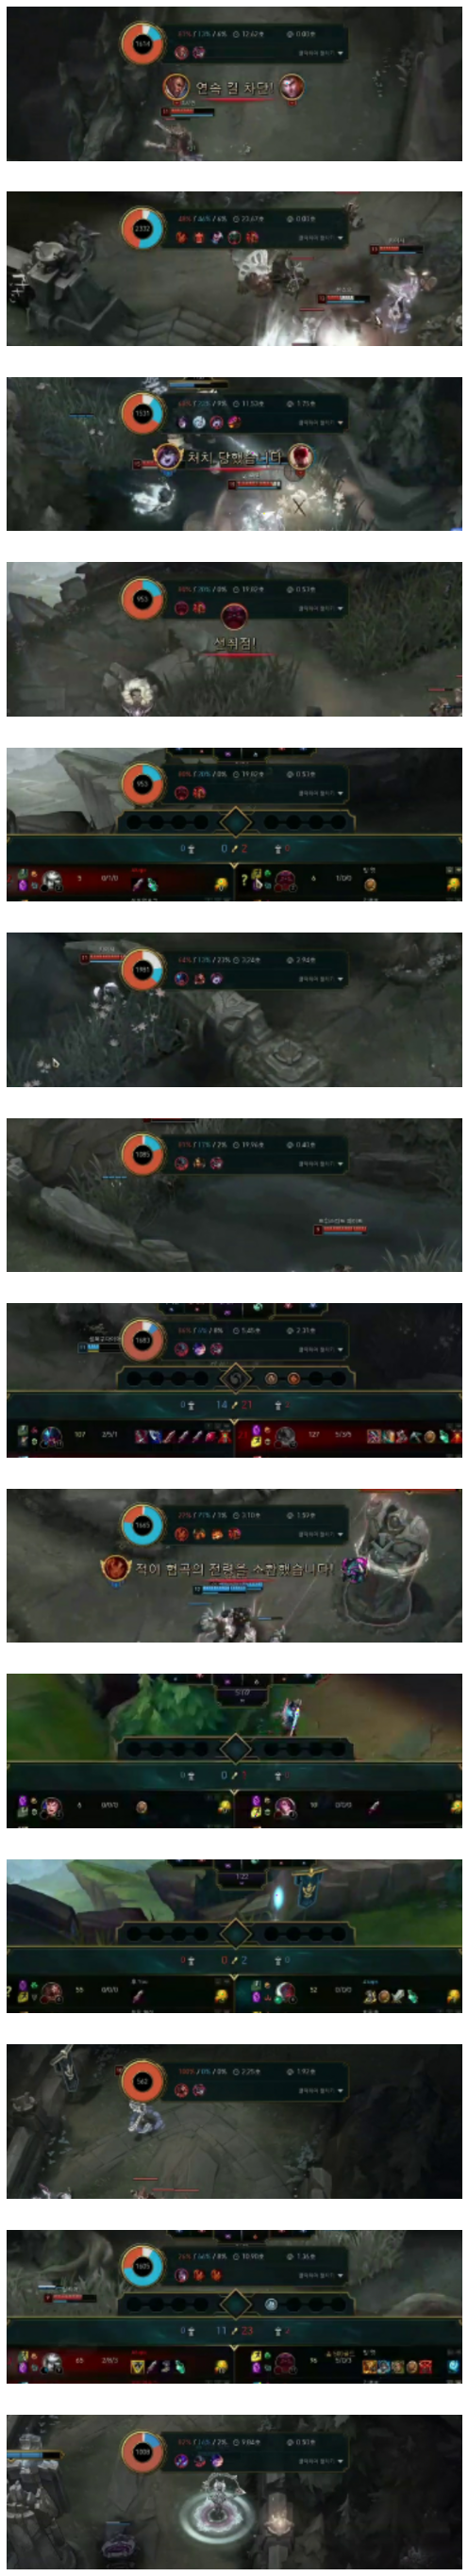

In [31]:
import matplotlib.pyplot as plt 

batch = renew_train_dataset.take(1)

for images, labels in batch:
    plt.figure(figsize = (20, 50))
    for i, image in enumerate(images):
        ax = plt.subplot(14, 1, i + 1)
        plt.imshow(image.numpy().astype('float32') / 255.)
        plt.axis('OFF')
        if i == 13:
            break
    break

## 8차 학습 전 평가

In [29]:
best_model = tf.keras.models.load_model('./kill_log_models/best_model.hdf5')

In [31]:
best_model.evaluate(renew_train_dataset)

39/39 [==============================] - 9s 222ms/step - loss: 0.0998 - accuracy: 0.9610


[0.09983093291521072, 0.9609755873680115]

In [30]:
best_model.evaluate(renew_test_dataset)

11/11 [==============================] - 3s 183ms/step - loss: 0.1244 - accuracy: 0.9648


[0.12443897128105164, 0.9648093581199646]

## 8차 학습

In [21]:
best_model = tf.keras.models.load_model('./kill_log_models/best_model.hdf5')

In [22]:
# val_loss에 따른 빠른 종료 -> 빠른 구현을 위해서 선택적으로 적용할 수 있다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

checkpoint = tf.keras.callbacks.ModelCheckpoint("./kill_log_models/model_t8.hdf5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

In [23]:
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [24]:
best_model.fit(renew_train_dataset, validation_data = renew_test_dataset, callbacks = [checkpoint], epochs = 10)

Epoch 1/10
39/39 [==============================] - 92s 2s/step - loss: 0.0839 - accuracy: 0.9714 - val_loss: 0.0652 - val_accuracy: 0.9883

Epoch 00001: val_loss improved from inf to 0.06521, saving model to ./kill_log_models\model_t8.hdf5
Epoch 2/10
39/39 [==============================] - 31s 793ms/step - loss: 0.0178 - accuracy: 0.9965 - val_loss: 0.0694 - val_accuracy: 0.9883

Epoch 00002: val_loss did not improve from 0.06521
Epoch 3/10
39/39 [==============================] - 34s 870ms/step - loss: 0.0154 - accuracy: 0.9981 - val_loss: 0.0640 - val_accuracy: 0.9883

Epoch 00003: val_loss improved from 0.06521 to 0.06398, saving model to ./kill_log_models\model_t8.hdf5
Epoch 4/10
39/39 [==============================] - 432s 11s/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9883

Epoch 00004: val_loss improved from 0.06398 to 0.06378, saving model to ./kill_log_models\model_t8.hdf5
Epoch 5/10
39/39 [==============================] - 42s 1s/step - los

In [25]:
best_model.evaluate(renew_test_dataset)

11/11 [==============================] - 3s 184ms/step - loss: 0.0628 - accuracy: 0.9883


[0.06284308433532715, 0.9882698059082031]

In [26]:
saved_model_t8 = tf.keras.models.load_model('./kill_log_models/model_t8.hdf5')

saved_model_t8.evaluate(renew_test_dataset)

11/11 [==============================] - 3s 183ms/step - loss: 0.0628 - accuracy: 0.9883


[0.06284308433532715, 0.9882698059082031]

In [28]:
saved_model_t8.evaluate(merged_testset)

25/25 [==============================] - 6s 165ms/step - loss: 0.0260 - accuracy: 0.9960


[0.025950880721211433, 0.9959893226623535]